## Traitement de l'image pour détecter la grille et redresser le sudoku


In [152]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os
from datetime import datetime
import glob
import pytesseract

In [153]:
# Initialisation de la caméra
# Ouvre la caméra 0 (caméra par défaut). Si plusieurs caméras sont branchées, on a juste a changer le 0 par 1,2,3,...
video_capture = cv2.VideoCapture(0)

# Définition du dossier où seront enregistrées les images capturées
image_enregistre_dossier = r"c:\Image_save"

# Vérifie si la caméra a été correctement ouverte
if not video_capture.isOpened():
    print("Erreur : Impossible d'ouvrir la caméra.")
    exit()

# Message d'instructions pour l'utilisateur
print("Caméra activée. Appuie sur 'q' pour quitter ou 'p' pour prendre une photo.")

# Boucle principale de capture
while True:
    # Capture une image depuis la caméra
    resultat, image_video = video_capture.read()

    # Si la capture échoue, on quitte la boucle
    if not resultat:
        print("Erreur lors de la lecture de la caméra.")
        break

    # Affiche l'image capturée dans une fenêtre nommée "Caméra_sudoku"
    cv2.imshow("Caméra_sudoku", image_video)

    # Lecture des touches clavier : attendre une touche 1 ms
    clavier = cv2.waitKey(1) & 0xFF

    # Si l'utilisateur appuie sur 'q' → quitter la boucle
    if clavier == ord('q'):
        print("Caméra désactivée.")
        break

    # Si l'utilisateur appuie sur 'p' → prendre une photo
    if clavier == ord('p'):
        # Génère un horodatage : année-mois-jour_heure-minute-seconde
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        # Construit le nom de fichier unique avec l’horodatage
        nom_fichier = os.path.join(image_enregistre_dossier, f"sudoku_capture_{timestamp}.png")

        # Enregistre l'image capturée dans le dossier
        cv2.imwrite(nom_fichier, image_video)

        # Vérifie si l'enregistrement a réussi
        if os.path.exists(nom_fichier):
            print(f"Image enregistrée dans le dossier : {nom_fichier}")
        else:
            print("Échec de l'enregistrement.") 

# Fermer la caméra
video_capture.release()

# Ferme toutes les fenêtres OpenCV ouvertes
cv2.destroyAllWindows()




Caméra activée. Appuie sur 'q' pour quitter ou 'p' pour prendre une photo.
Caméra désactivée.


Image la plus récente utilisée : C:\Image_save\sudoku_capture_2025-06-12_21-42-38.png


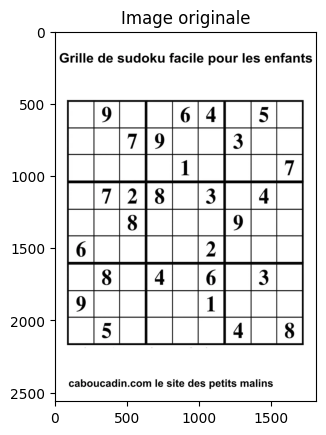

In [154]:
# Définir le dossier où les images sont enregistrées
image_enregistre_dossier = r"C:\Image_save"  

# Trouver le dernier fichier .png dans le dossier d'enregistrement
fichiers_png = glob.glob(os.path.join(image_enregistre_dossier, "*.png"))
dernier_fichier = max(fichiers_png, key=os.path.getctime) if fichiers_png else None

if dernier_fichier:
    image_path = dernier_fichier
    print(f"Image la plus récente utilisée : {image_path}")
else:
    print("Aucune image trouvée dans le dossier.")
    exit()
image = cv2.imread(image_path)
# Afficher l'image originale 
plt.figure()
plt.title("Image originale")
# Convertir l'image en RGB pour l'affichage avec matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


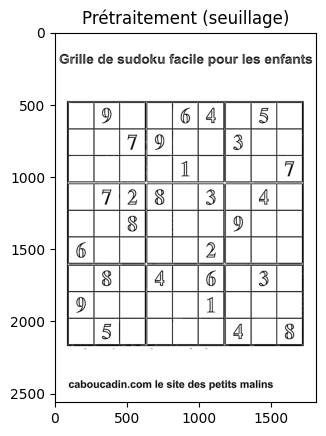

In [155]:
# Fonction de prétraitement de l'image
def pretraitement(image):
    # Convertit l'image en niveaux de gris pour simplifier le traitement.
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #Réduit les petits bruits ou variations (comme les ombres ou pixels isolés).
    blur = cv2.GaussianBlur(gris, (3, 3), 6)
    #Transforme l’image floue en noir et blanc, pixel par pixel, en s’adaptant à la luminosité.
    #255 est la valeur maximale (blanc), 1 est le type de méthode d'adaptation, 11 est la taille 
    # du bloc pour l'adaptation, et 2 est la constante soustraite de la moyenne.
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return thresh

threshold = pretraitement(image)

plt.figure()
plt.title("Prétraitement (seuillage)")
plt.imshow(threshold, cmap='binary')
plt.show()


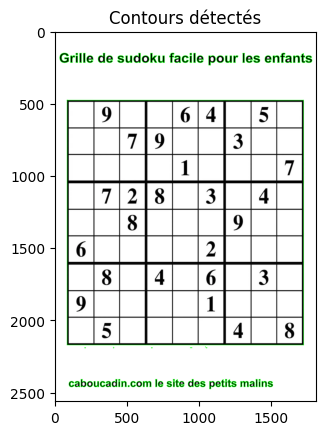

In [156]:
# On crée une copie de l’image couleur pour dessiner par-dessus sans modifier l’originale.
contour_debug = image.copy()
# Détection des contours dans l'image prétraitée.
# cv2.RETR_EXTERNAL permet de ne détecter que les contours extérieurs.
# cv2.CHAIN_APPROX_SIMPLE réduit le nombre de points dans les contours.
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# On dessine les contours détectés sur la copie de l'image.
cv2.drawContours(contour_debug, contours, -1, (0, 255, 0), 2)

plt.figure()
plt.title("Contours détectés")
plt.imshow(cv2.cvtColor(contour_debug, cv2.COLOR_BGR2RGB))
plt.show()


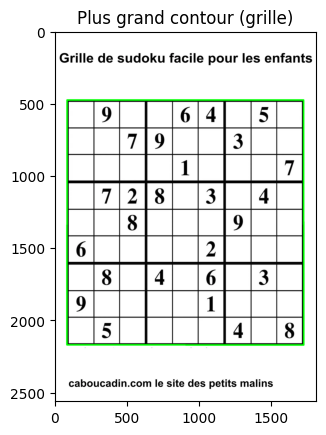

In [157]:

# Fonction pour trouver le plus grand contour qui ressemble à un quadrilatère (comme une grille de sudoku)
def trouver_plus_grand_contour(contours):
    # Stocker le plus grand contour trouvé, initialisé à None
    biggest = None
    # mémorise le plus grand contour trouvé jusqu'ici, initialisé à 0
    max_area = 0
    # Parcourir tous les contours détectés
    for c in contours:
        #calcule la surface de chaque contour
        area = cv2.contourArea(c)
        # On ne garde que les contours dont la surface est significative (plus de 100 pixels)
        if area > 100:
            # calcule le périmètre
            perimètre = cv2.arcLength(c, True)
            # approx contiendra typiquement 4 points si c’est un rectangle/quadrilatère
            approx = cv2.approxPolyDP(c, 0.02 * perimètre, True)
            # On garde le contour s’il a 4 points (quadrilatère) et s’il est plus grand que le précédent
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest
# On applique la fonction à la liste des contours détectés
biggest = trouver_plus_grand_contour(contours)
# On crée une copie de l'image originale pour dessiner le plus grand contour trouvé
contour_red = image.copy()

# Si un contour quadrilatère a été trouvé, on le dessine en vert sur l'image originale
if isinstance(biggest, np.ndarray) and biggest.shape[0] == 4:
    # -1 signifie que l'on dessine tous les points du contour
    # (0, 255, 0) est la couleur verte en BGR
    # 10 est l'épaisseur de la ligne
    cv2.drawContours(contour_red, [biggest], -1, (0, 255, 0), 10)

    plt.figure()
    plt.title("Plus grand contour (grille)")
    # Convertir l'image en RGB pour l'affichage avec matplotlib
    plt.imshow(cv2.cvtColor(contour_red, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Aucun contour quadrilatère détecté")


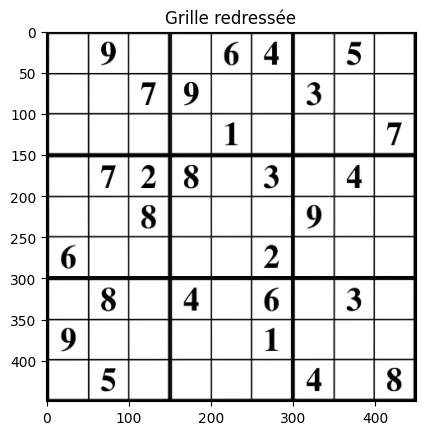

In [158]:
# Fonctione de réorganisation des points du quadrilatère pour les mettre dans l'ordre
def reorder(points):
    # On s'assure que les points sont dans un format approprié
    points = points.reshape((4, 2))
    # On crée un tableau pour les nouveaux points réordonnés
    points_new = np.zeros((4, 1, 2), dtype=np.int32)
    # Calcule la somme et la différence des coordonnées pour identifier les coins
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)] # Coin supérieur gauche
    points_new[3] = points[np.argmax(add)] # Coin inférieur droit
    diff = np.diff(points, axis=1)
    points_new[1] = points[np.argmin(diff)] # Coin supérieur droit
    points_new[2] = points[np.argmax(diff)] # Coin inférieur gauche
    return points_new

# Si on a trouvé un contour quadrilatère, on le réorganise pour la transformation perspective
if biggest is not None and len(biggest) == 4:
    biggest = reorder(biggest)
    pts1 = np.float32(biggest)
    # On définit les points de destination pour la transformation perspective
    pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])
    # On crée la matrice de transformation perspective pour redresser la grille
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    # On applique la transformation à l'image
    imagewrap = cv2.warpPerspective(image, matrix, (450, 450))
    # Convertir l'image redressée en RGB pour l'affichage
    imagewrap = cv2.cvtColor(imagewrap, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.title("Grille redressée")
    plt.imshow(imagewrap)
    plt.axis('on')
    plt.show()
else:
    print("Grille non trouvée pour transformation")


Matrice (0 = vide, 1 = chiffre détecté) :
0 1 0 0 1 1 0 1 0
0 0 1 1 0 0 1 0 0
0 0 0 0 1 0 0 0 1
0 1 1 1 0 1 0 1 0
0 0 1 0 0 0 1 0 0
1 0 0 0 0 1 0 0 0
0 1 0 1 0 1 0 1 0
1 0 0 0 0 1 0 0 0
0 1 0 0 0 0 1 0 1

Prédictions du modèle :


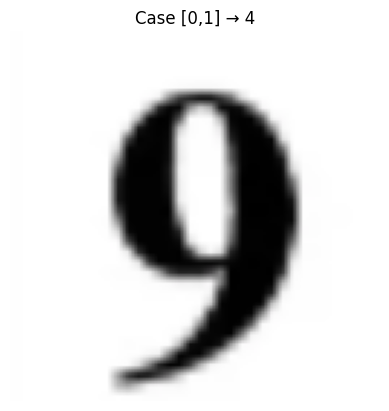

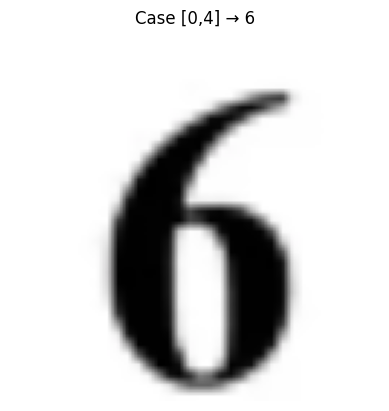

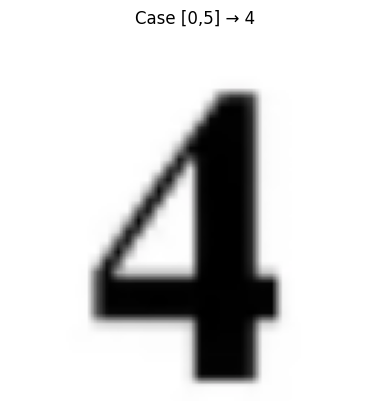

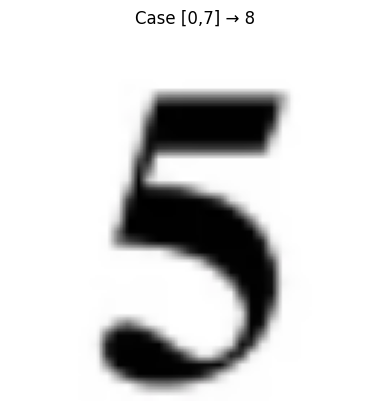

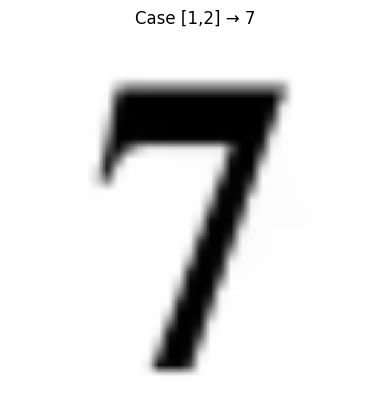

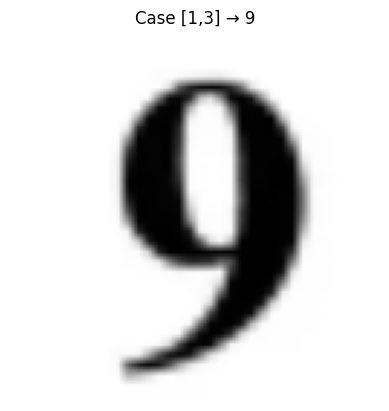

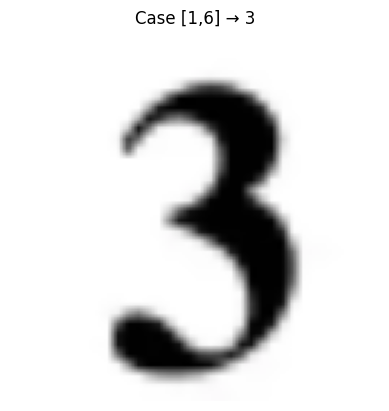

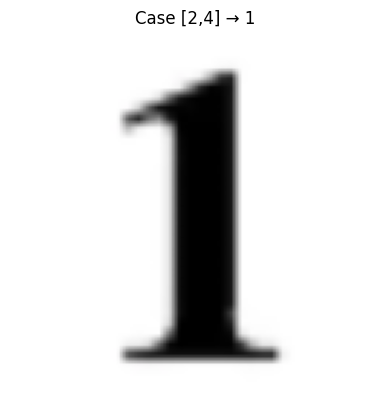

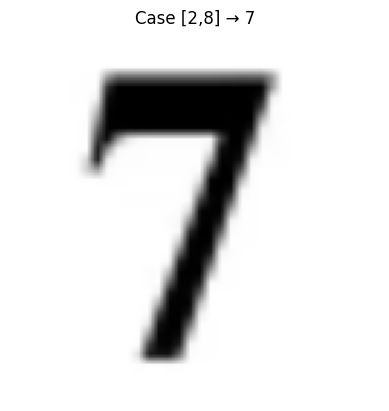

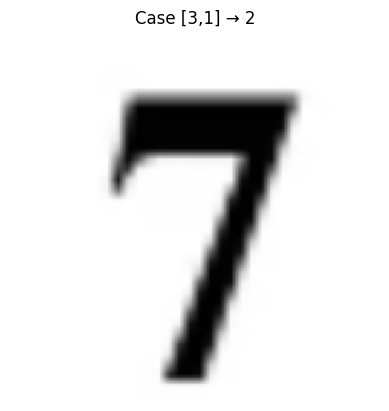

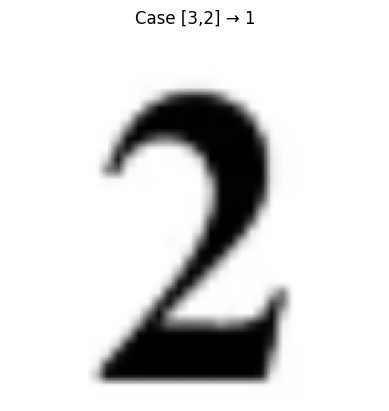

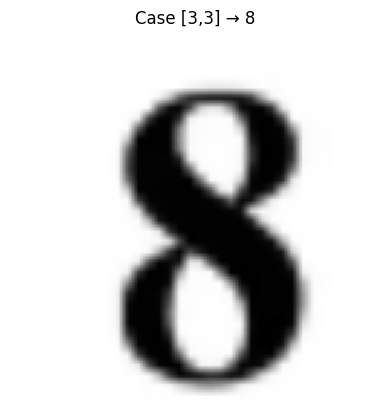

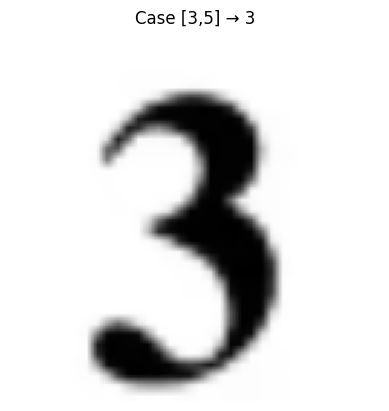

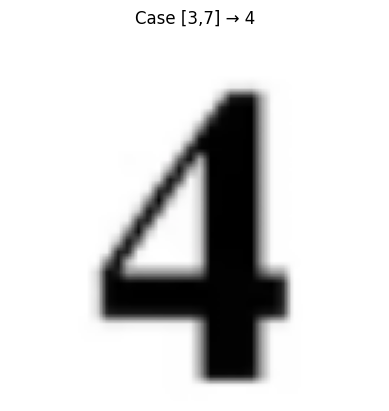

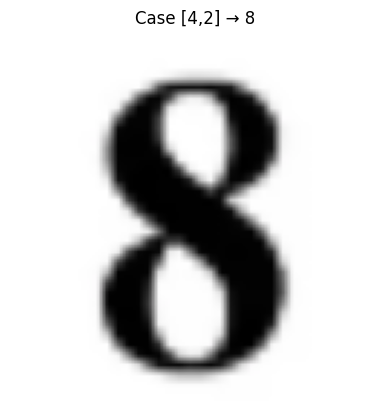

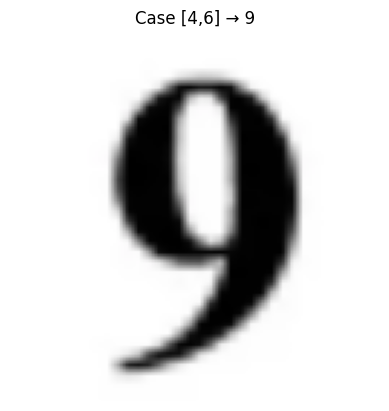

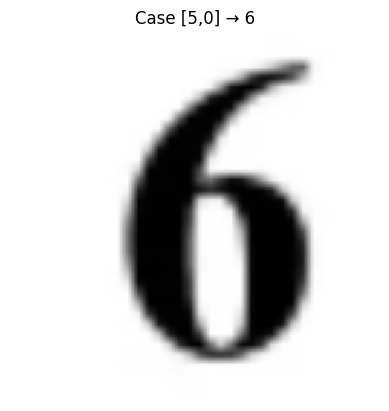

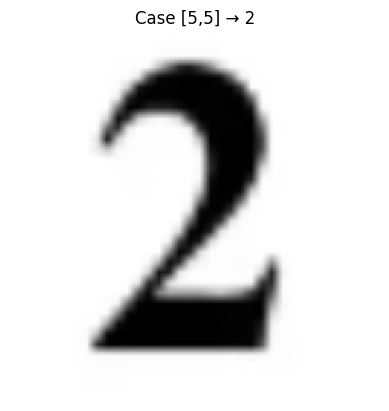

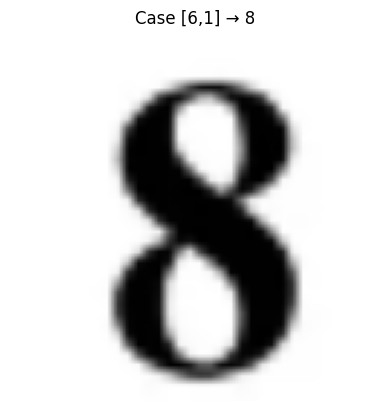

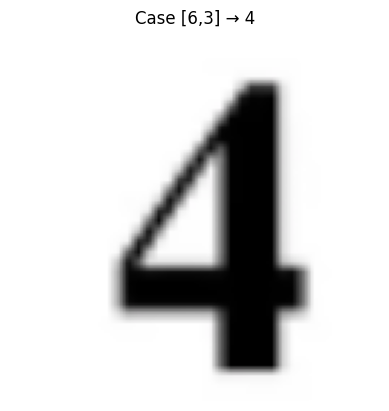

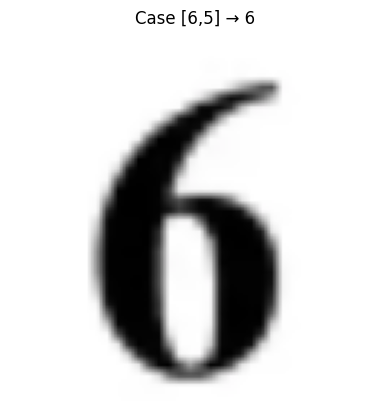

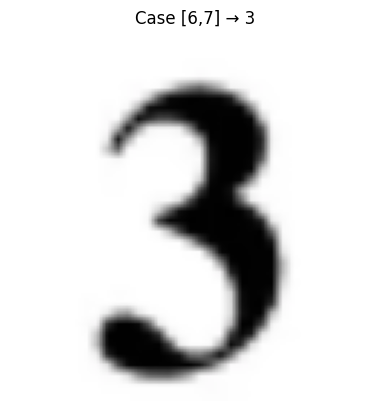

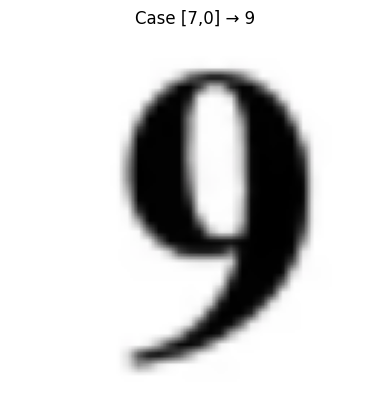

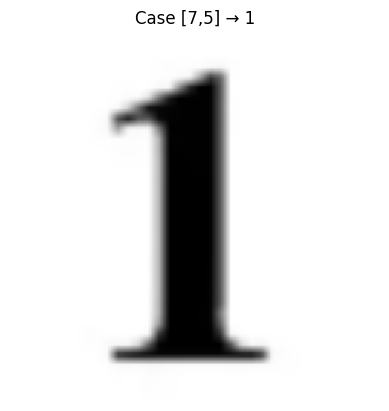

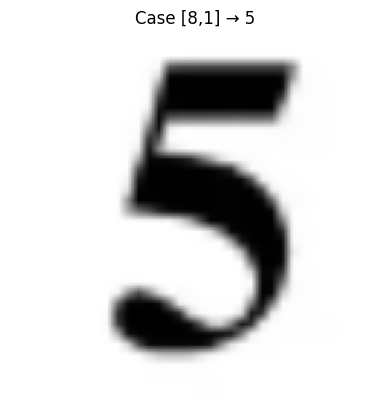

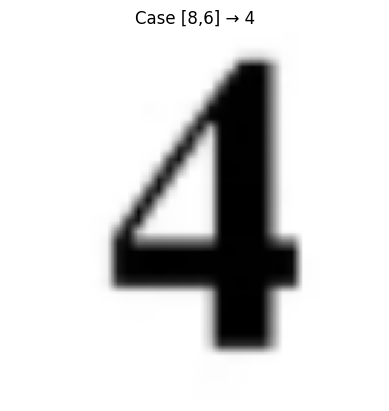

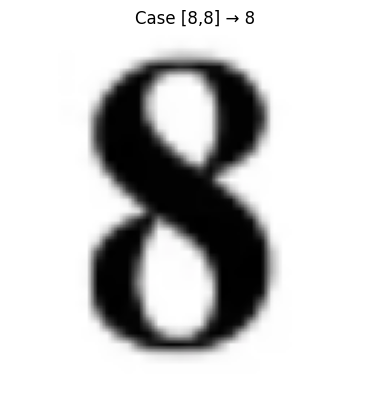


Grille finale :
. 4 . . 6 4 . 8 .
. . 7 9 . . 3 . .
. . . . 1 . . . 7
. 2 1 8 . 3 . 4 .
. . 8 . . . 9 . .
6 . . . . 2 . . .
. 8 . 4 . 6 . 3 .
9 . . . . 1 . . .
. 5 . . . . 4 . 8
✅ Case [0,1] mise à jour avec la valeur 9.
✅ Case [0,7] mise à jour avec la valeur 5.
✅ Case [3,1] mise à jour avec la valeur 7.
✅ Case [3,2] mise à jour avec la valeur 2.

✅ Grille mise à jour finale :
. 9 . . 6 4 . 5 .
. . 7 9 . . 3 . .
. . . . 1 . . . 7
. 7 2 8 . 3 . 4 .
. . 8 . . . 9 . .
6 . . . . 2 . . .
. 8 . 4 . 6 . 3 .
9 . . . . 1 . . .
. 5 . . . . 4 . 8


In [161]:
# Charger le modèle
model = keras.models.load_model("c:/Image_save/model14.keras")

# Prétraitement
gray = cv2.cvtColor(imagewrap, cv2.COLOR_RGB2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 3)

grille_detectee = np.zeros((9, 9), dtype=int)
grille_valeurs = np.zeros((9, 9), dtype=int)
case_size = 50

# Détection des cases contenant un chiffre
for i in range(9):
    for j in range(9):
        x = j * case_size
        y = i * case_size
        case_img = thresh[y:y+case_size, x:x+case_size]
        case_img = cv2.medianBlur(case_img, 3)

        if cv2.countNonZero(case_img) > 400:
            grille_detectee[i, j] = 1

print("Matrice (0 = vide, 1 = chiffre détecté) :")
for row in grille_detectee:
    print(" ".join(str(val) for val in row))

# Prédictions
print("\nPrédictions du modèle :")
for i in range(9):
    for j in range(9):
        if grille_detectee[i, j] == 1:
            x = j * case_size
            y = i * case_size
            border = 7
            case = imagewrap[y+border:y+case_size-border, x+border:x+case_size-border]
            case_rgb = cv2.cvtColor(case, cv2.COLOR_BGR2RGB)
            case_resized = cv2.resize(case_rgb, (128, 128))
            input_img = np.expand_dims(case_resized, axis=0)
            prediction = model.predict(input_img, verbose=0)
            chiffre = np.argmax(prediction)
            grille_valeurs[i, j] = chiffre

            # Affichage de la case
            plt.imshow(case_resized)
            plt.title(f"Case [{i},{j}] → {chiffre}")
            plt.axis("off")
            plt.show()

# Affichage grille finale
print("\nGrille finale :")
for row in grille_valeurs:
    print(" ".join(str(val) if val != 0 else "." for val in row))

# Interaction utilisateur : vérification
choix = input("\nAppuie sur 'o' si tout est correct, ou sur 'k' si tu veux corriger des prédictions : ").strip().lower()

while choix == "k":
    try:
        coords = input("Entre les coordonnées de la case à modifier (ex: 3 4) ou 'f' pour finir : ").strip().lower()
        if coords == "f":
            break

        i, j = map(int, coords.split())
        if 0 <= i < 9 and 0 <= j < 9:
            new_val = int(input(f"Entrez la nouvelle valeur pour la case [{i},{j}] : "))
            if 0 <= new_val <= 9:
                grille_valeurs[i, j] = new_val
                print(f"✅ Case [{i},{j}] mise à jour avec la valeur {new_val}.")
            else:
                print("❌ Valeur invalide. Elle doit être entre 0 et 9.")
        else:
            print("❌ Coordonnées hors limites.")
    except:
        print("❌ Entrée invalide. Réessaie.")

# Affichage final
print("\n✅ Grille mise à jour finale :")
for row in grille_valeurs:
    print(" ".join(str(val) if val != 0 else "." for val in row))




In [162]:
# Sudoku = [
# 	0, 0, 0, 7, 0, 0, 0, 8, 0,
# 	0, 9, 0, 0, 0, 3, 1, 0, 0,
# 	0, 0, 6, 8, 0, 5, 0, 7, 0,
# 	0, 2, 0, 6, 0, 0, 0, 4, 9,
# 	0, 0, 0, 2, 0, 0, 0, 5, 0,
# 	0, 0, 8, 0, 4, 0, 0, 0, 7,
# 	0, 0, 0, 9, 0, 0, 0, 3, 0,
# 	3, 7, 0, 0, 0, 0, 0, 0, 6,
# 	1, 0, 5, 0, 0, 4, 0, 0, 0
# ]
# Conversion grille 9x9 en format 1D
Sudoku = grille_valeurs.flatten().tolist()


# Fonction pour afficher le Sudoku de manière lisible
def print_sudoku(sudoku):
    for i in range(9):
        row = sudoku[i*9:(i+1)*9]
        print(" ".join(str(num) if num != 0 else "." for num in row))
print_sudoku(Sudoku)
# Fonction pour vérifier si un nombre peut être placé dans une case donnée
def is_valid(sudoku, row, col, num):
    for i in range(9):
        if sudoku[row * 9 + i] == num or sudoku[i * 9 + col] == num:
            return False
    start_row = (row // 3) * 3
    start_col = (col // 3) * 3
    for i in range(3):
        for j in range(3):
            if sudoku[(start_row + i) * 9 + (start_col + j)] == num:
                return False
    return True
is_valid(Sudoku, 0, 0, 5)
# Fonction récursive pour résoudre le Sudoku
def solve_sudoku(sudoku):
    for i in range(9):
        for j in range(9):
            if sudoku[i * 9 + j] == 0:
                for num in range(1, 10):
                    if is_valid(sudoku, i, j, num):
                        sudoku[i * 9 + j] = num
                        if solve_sudoku(sudoku):
                            return True
                        sudoku[i * 9 + j] = 0
                return False
    return True
solve_sudoku(Sudoku)
print("\nSolved Sudoku:")
print_sudoku(Sudoku)




. 9 . . 6 4 . 5 .
. . 7 9 . . 3 . .
. . . . 1 . . . 7
. 7 2 8 . 3 . 4 .
. . 8 . . . 9 . .
6 . . . . 2 . . .
. 8 . 4 . 6 . 3 .
9 . . . . 1 . . .
. 5 . . . . 4 . 8

Solved Sudoku:
8 9 3 7 6 4 2 5 1
1 6 7 9 2 5 3 8 4
4 2 5 3 1 8 6 9 7
5 7 2 8 9 3 1 4 6
3 1 8 6 4 7 9 2 5
6 4 9 1 5 2 8 7 3
2 8 1 4 7 6 5 3 9
9 3 4 5 8 1 7 6 2
7 5 6 2 3 9 4 1 8


In [165]:
def dessiner_sudoku(grille_initiale, grille_finale, taille=450, couleur_depart=(0, 0, 0), couleur_solution=(255, 0, 0)):
    img = 255 * np.ones((taille, taille, 3), dtype=np.uint8)
    case = taille // 9
    font = cv2.FONT_HERSHEY_SIMPLEX

    # Tracer les lignes de la grille
    for i in range(10):
        epaisseur = 2 if i % 3 == 0 else 1
        # lignes horizontales
        cv2.line(img, (0, i * case), (taille, i * case), (0, 0, 0), epaisseur)
        # lignes verticales
        cv2.line(img, (i * case, 0), (i * case, taille), (0, 0, 0), epaisseur)

    # Affichage des chiffres
    for i in range(9):
        for j in range(9):
            val = grille_finale[i * 9 + j]
            if val != 0:
                texte = str(val)
                x = j * case + 15
                y = (i + 1) * case - 10
                couleur = couleur_depart if grille_initiale[i * 9 + j] != 0 else couleur_solution
                cv2.putText(img, texte, (x, y), font, 1, couleur, 2, cv2.LINE_AA)

    return img
# Affichage graphique du Sudoku résolu

# Récupérer la grille initiale (avant résolution)
grille_initiale = grille_valeurs.flatten().tolist()

# La grille résolue (mise à jour par l'algorithme)
grille_finale = Sudoku  # c’est la version résolue après solve_sudoku

# Dessiner l'image
img = dessiner_sudoku(grille_initiale, grille_finale)

# Afficher l'image dans une fenêtre
cv2.imshow("Sudoku Résolu", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# # Optionnel : enregistrer l’image
# cv2.imwrite("sudoku_resolu.png", img)
